In [5]:
from __future__ import absolute_import, division, print_function
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K


import gc
import argparse


In [ ]:
'''
gpus = tf.config.list_physical_devices('GPU')
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.set_visible_devices(gpus[0], 'GPU')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
'''



In [12]:
# standard numerical library imports
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
import os
import sys

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, to_categorical


In [13]:
sys.path.append('../20240503')
import DCTR


In [48]:
def get_rwgt(model_list, x1_plt, x1_nrm, batch_size = 5*8192):
    rwgt_list = np.empty(shape = (len(model_list),len(x1_plt)), dtype = np.float64)
    for i, model in enumerate(model_list):
        K.clear_session()
        with tf.device('/cpu:0'):
            dctr = tf.keras.models.load_model(model)
            preds = dctr.predict(x1_nrm, batch_size=batch_size)
            rwgt = preds[:,0]/preds[:,1]
            # set wgts of events with pt > 1000 to 1
            for k, _ in enumerate(rwgt):
                if (x1_plt[k,0]>1000):
                    rwgt[k] = 1

        rwgt_list[i] = rwgt
    
    K.clear_session()
    return rwgt_list


In [45]:
data_dir = '/tf/data/BachelorThesis_Data/Valentinas_Samples/test_samples_ready'


In [9]:
dataset=np.load(f'{data_dir}/X_Nom_TestAll_13TeV_test_plot.npz')
print(dataset.files)
X1_test=dataset['a'][:int(1e7)] # limit for now, to test
X1_plot=dataset['b'][:int(1e7)]

X1_plot_wgt = np.array([1. for i in range(X1_plot.shape[0])])

print(X1_test.shape)
print(X1_plot.shape)


['a', 'b']
(10000000, 2, 6)
(10000000, 8)


In [10]:
dataset=np.load(f'{data_dir}/X_Up_TestAll_13TeV_test_plot.npz')
print(dataset.files)
X0_test=dataset['a'][:int(1e7)] # limit for now, to test
X0_plot=dataset['b'][:int(1e7)]

X0_plot_wgt = np.array([1. for i in range(X0_plot.shape[0])])

print(X0_test.shape)
print(X0_plot.shape)


['a', 'b']
(10000000, 2, 6)
(10000000, 8)


In [46]:
model_dir = '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models'
model_list = []

for i in range(1, 13):
    model_list.append(f'{model_dir}/DCTR_training_iter_{i:02d}.h5')

print(model_list)


['/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_01.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_02.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_03.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_04.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_05.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_06.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_07.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_08.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_09.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_10.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_

In [49]:
wgts_list = get_rwgt(model_list, X1_plot, X1_test)

print(np.shape(weights_1))


(12, 10000000)


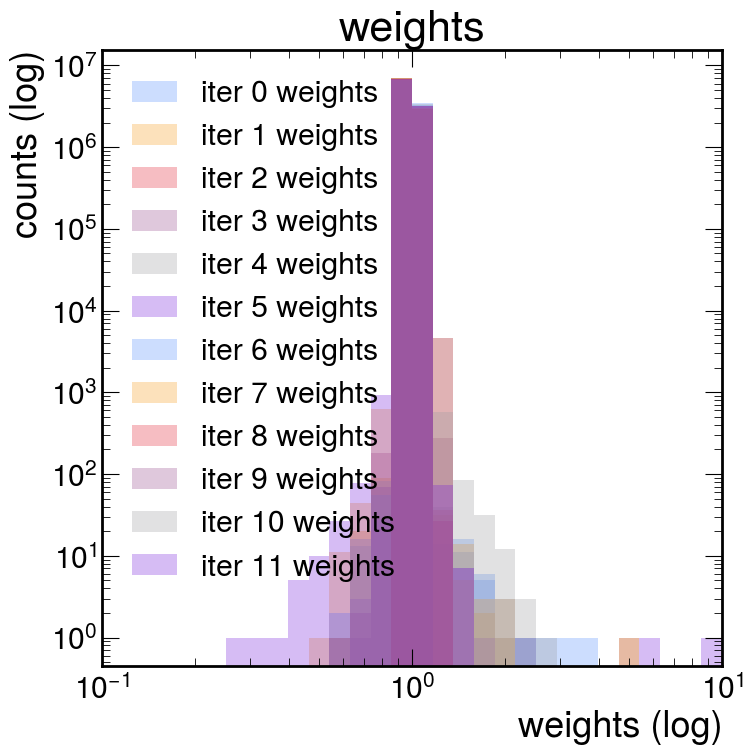

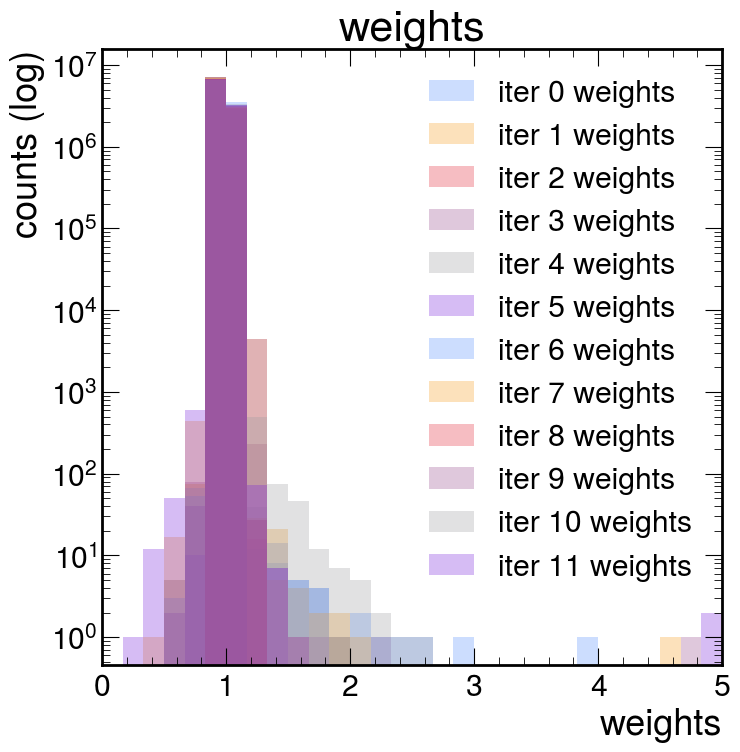

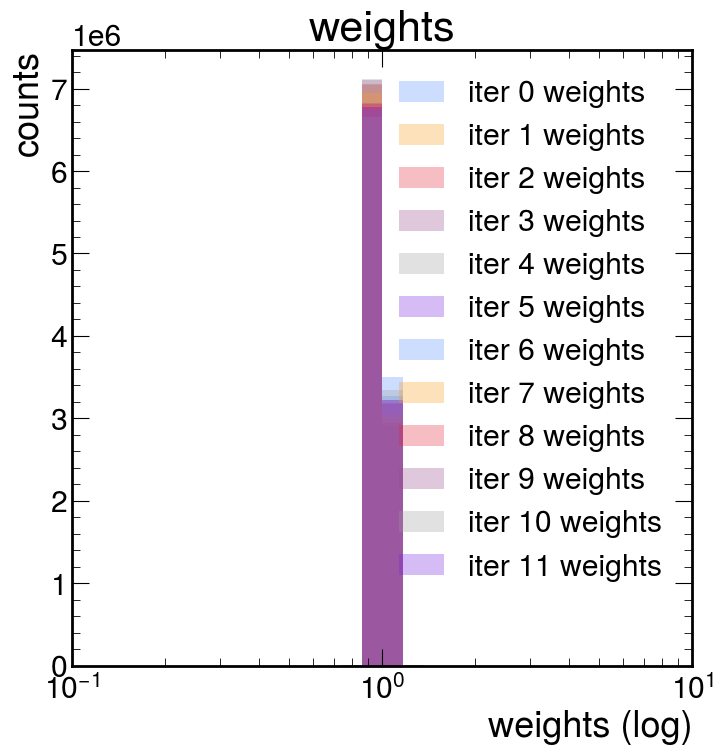

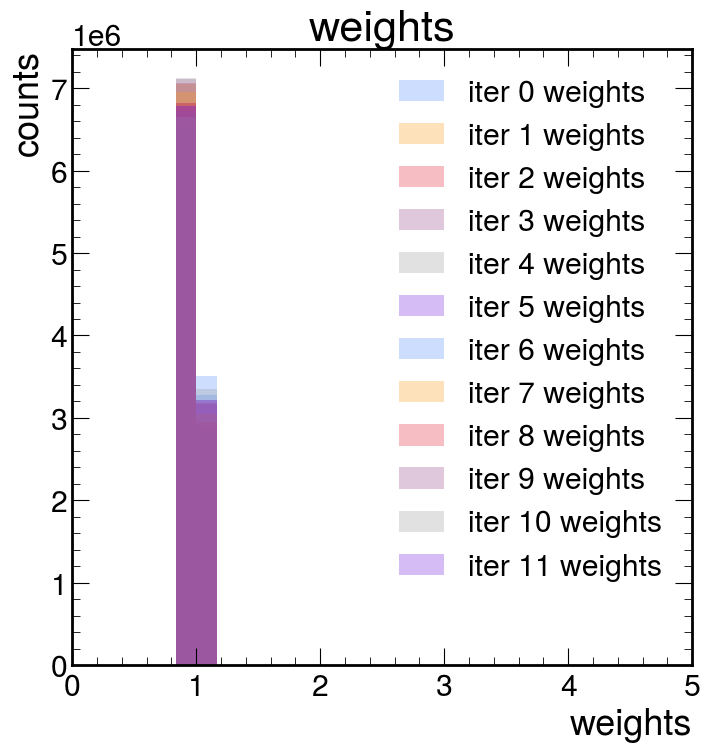

In [38]:
# plot and check dctr rwgt
wgts_args = []
for i, _ in enumerate(wgts_list):
    wgts_args.append([wgts_list[i], rf'iter {i} weights'])

# y log scale
DCTR.plot_weights(wgts_args, start = 0.1, stop = 10) # log x
DCTR.plot_weights(wgts_args, start = 0, stop = 5, xscale='lin') # linear x

# y lin scale
DCTR.plot_weights(wgts_args, start = 0.1, stop = 10, yscale='lin') # log x
DCTR.plot_weights(wgts_args, start = 0, stop = 5, xscale='lin', yscale='lin') # linear x


In [42]:
# check weights

# when building ratio of square root of squared weights, the value we are comparing against has wgt = 1 for all events 
# -> /sqrt(num_events) is all we need

def get_wgts_stats(wgts_list):
    min_wgt_list    = []
    max_wgt_list    = []
    mean_wgt_list   = []
    ratio_wgts_list = []
    sqrt_num_events = math.sqrt(len(wgts_list[0]))
    for i, wgts in enumerate(wgts_list):
        min_wgt_list.append(np.min(wgts))
        max_wgt_list.append(np.max(wgts))
        mean_wgt_list.append(np.mean(wgts))
        
        sqrt_sum_wgts_squared = math.sqrt(np.sum(np.power(wgts, 2)))
        ratio_wgts_list.append(sqrt_sum_wgts_squared/sqrt_num_events)

    return np.array(min_wgt_list), np.array(max_wgt_list), np.array(mean_wgt_list), np.array(ratio_wgts_list)


In [69]:
min_wgt_list, max_wgt_list, mean_wgt_list, ratio_wgt_list = get_wgts_stats(wgts_list)
np.set_printoptions(precision=5, suppress=True)

print(f'{min_wgt_list    = }\n')
print(f'{max_wgt_list    = }\n')
print(f'{mean_wgt_list   = }\n')
print(f'{ratio_wgt_list = }\n')

mean_mean_wgt = np.mean(mean_wgt_list)
std_mean_wgt  = np.std(mean_wgt_list)

mean_ratio_wgt = np.mean(ratio_wgt_list)
std_ratio_wgt  = np.std(ratio_wgt_list)

print(f'mean weights:\n\
{mean_mean_wgt:.5f} +/- {std_mean_wgt:.5f}\n')

print(f'ratio of sqrt of sum of squared weights:\n\
{mean_ratio_wgt:.5f} +/- {std_ratio_wgt:.5f}')


min_wgt_list    = array([0.87526, 0.54173, 0.88436, 0.69375, 0.92471, 0.71335, 0.59631,
       0.48652, 0.86569, 0.62288, 0.60032, 0.28764])

max_wgt_list    = array([3.883  , 1.95081, 1.23524, 4.75238, 1.21143, 9.55826, 2.94078,
       4.66327, 1.33022, 1.16291, 2.60122, 1.51122])

mean_wgt_list   = array([1.00329, 0.99699, 0.99979, 0.99768, 0.99913, 1.00091, 1.0028 ,
       0.99801, 1.00154, 1.00255, 1.00079, 1.00137])

ratio_wgt_list = array([1.00413, 0.99775, 1.00065, 0.99851, 0.9999 , 1.00173, 1.00356,
       0.99889, 1.00225, 1.00344, 1.00159, 1.00229])

mean weights:
1.00040 +/- 0.00200

ratio of sqrt of sum of squared weights:
1.00122 +/- 0.00201


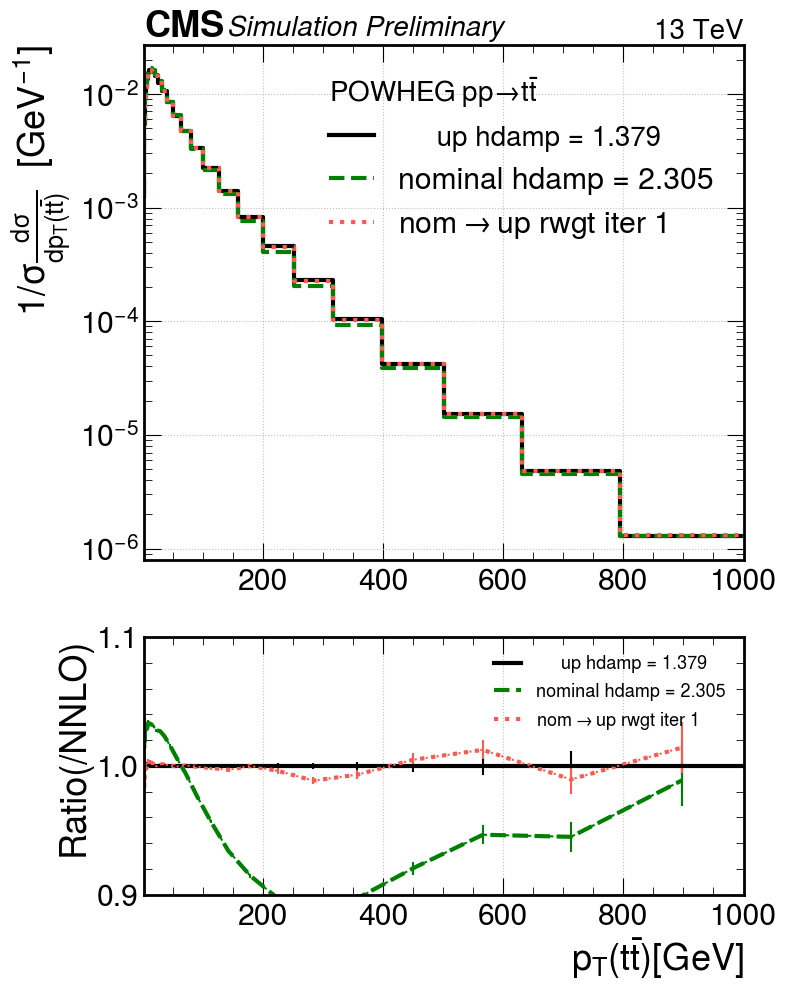


 iteration 1: chi2, mae, 
 1.1097049951384743, 522.4283974623578 



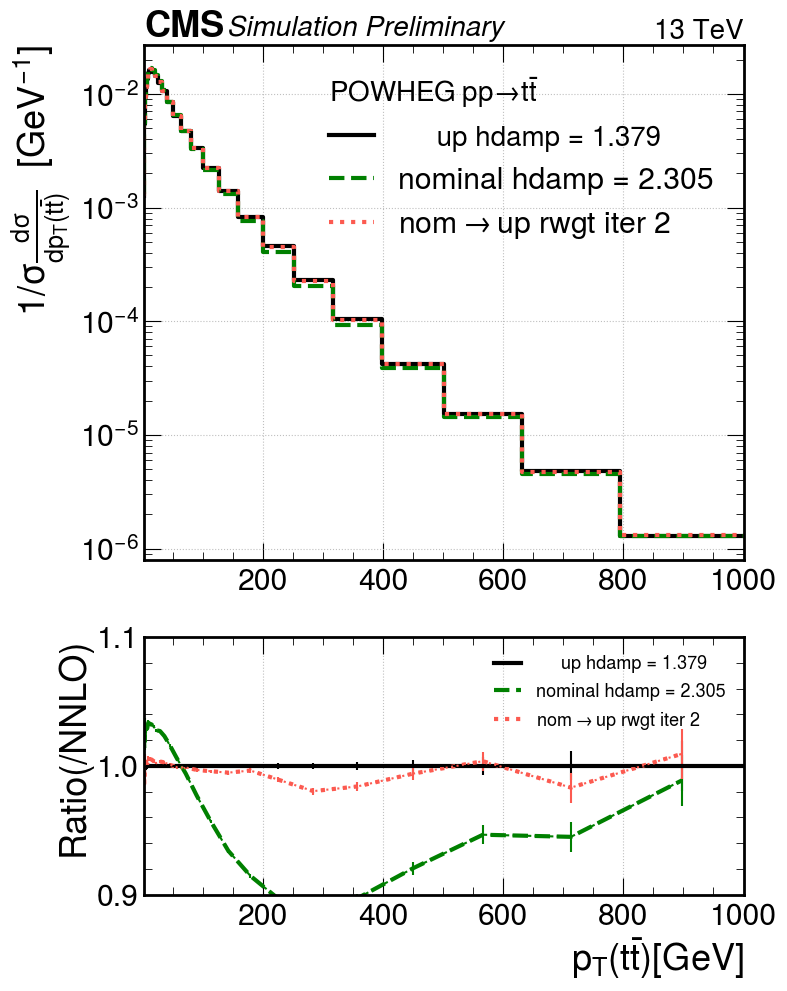


 iteration 2: chi2, mae, 
 3.7310249170129253, 1182.0629762073577 



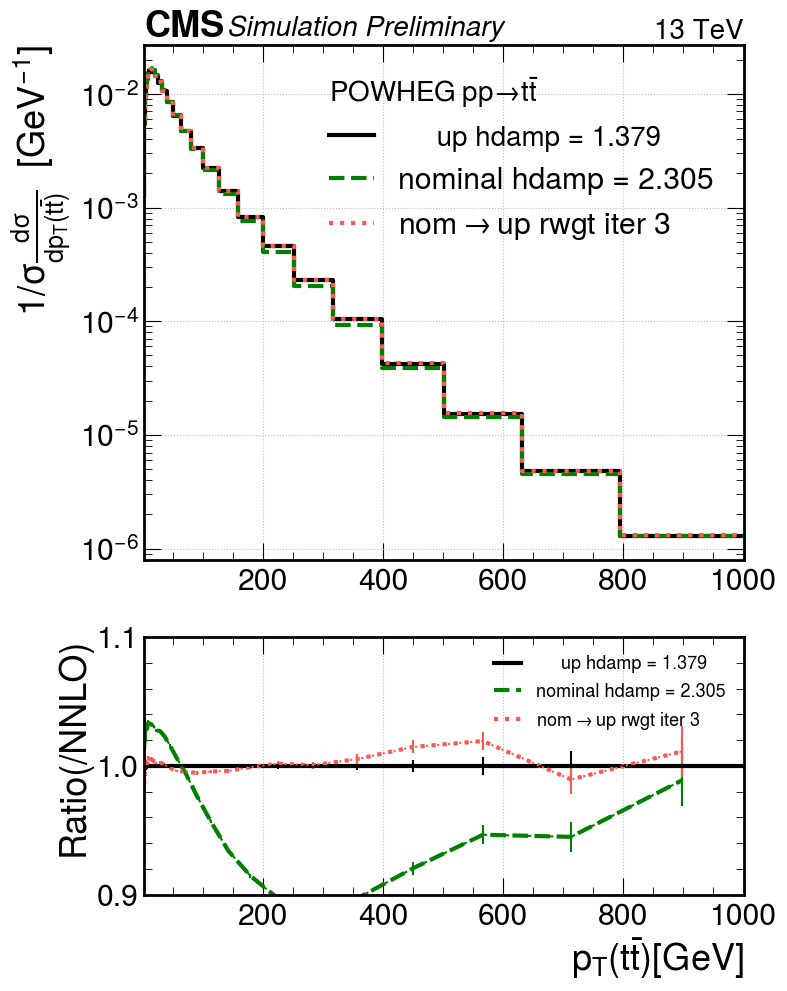


 iteration 3: chi2, mae, 
 2.7212304464497787, 1140.058123010039 



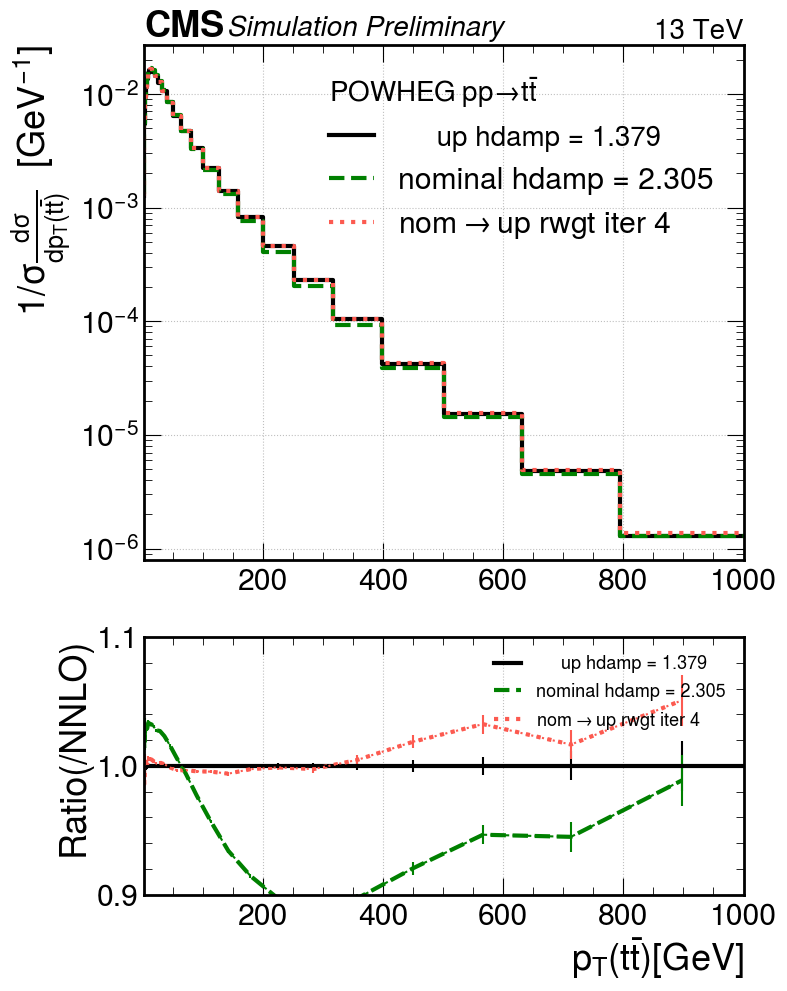


 iteration 4: chi2, mae, 
 2.9328329134781264, 1111.009177621549 



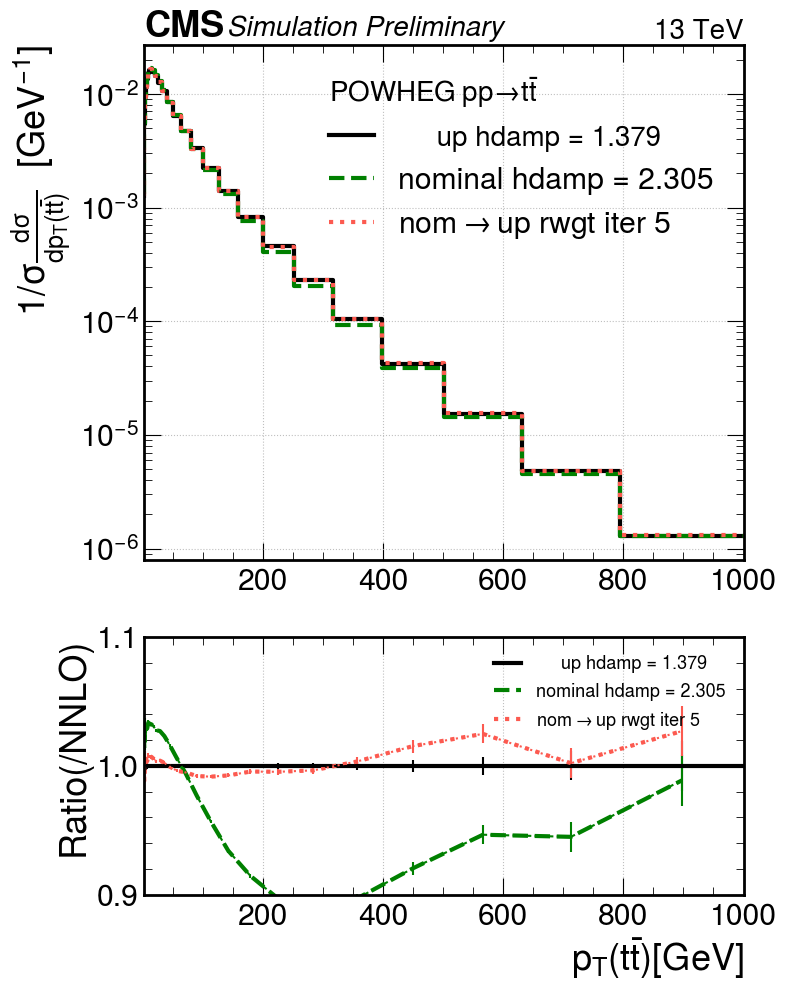


 iteration 5: chi2, mae, 
 5.303845767926037, 1646.6340473979856 



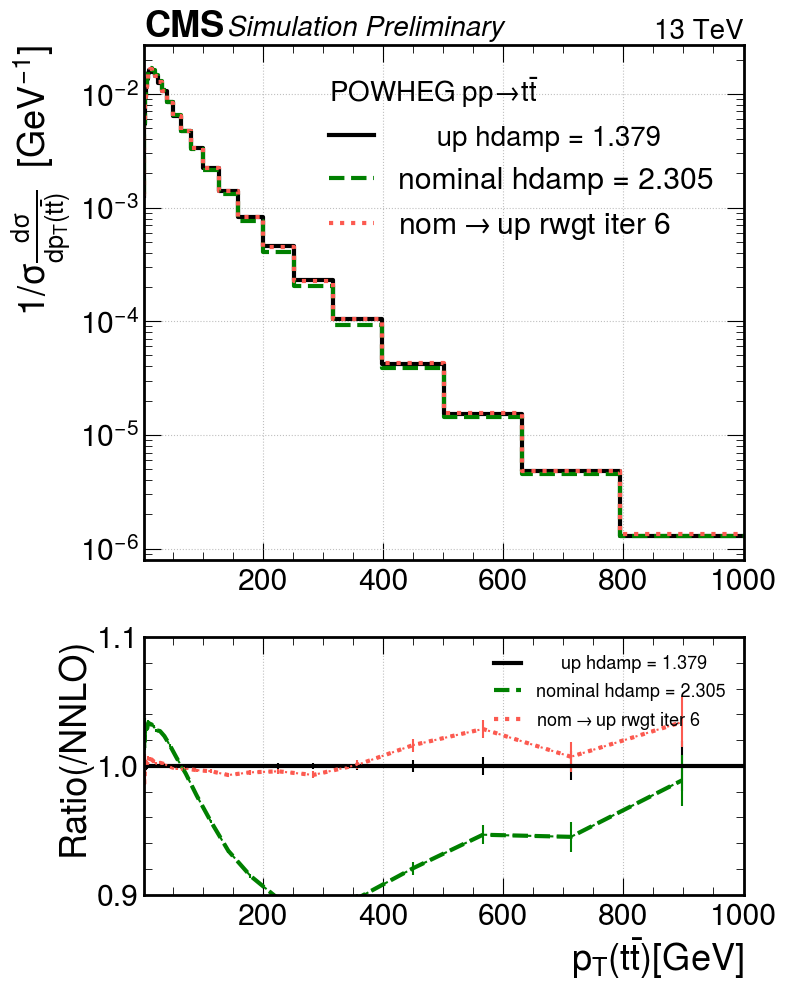


 iteration 6: chi2, mae, 
 2.7861070188684818, 1087.3116304340588 



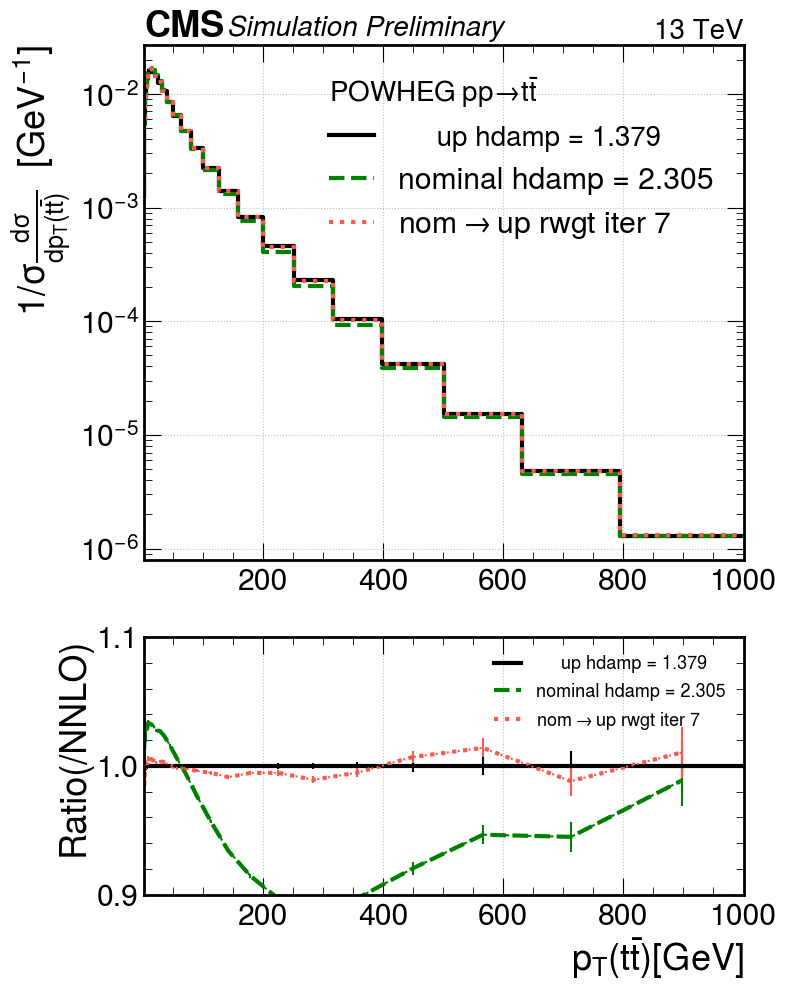


 iteration 7: chi2, mae, 
 3.2537107555370275, 1245.048094573015 



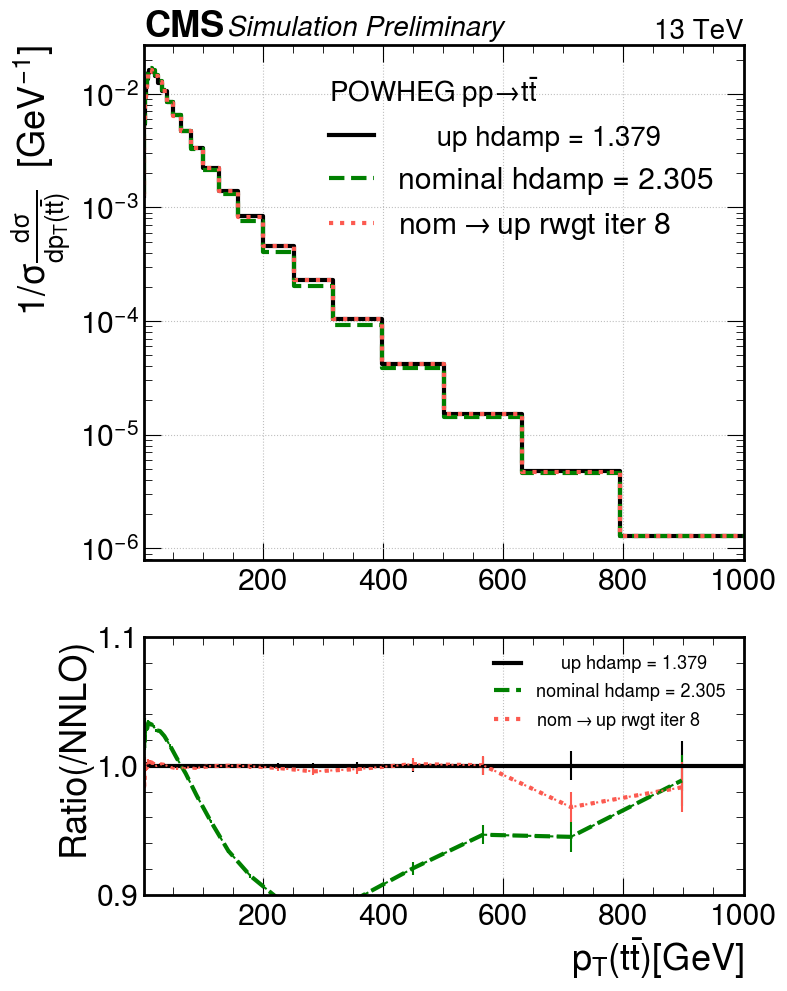


 iteration 8: chi2, mae, 
 0.7875229134053131, 459.1813051480429 



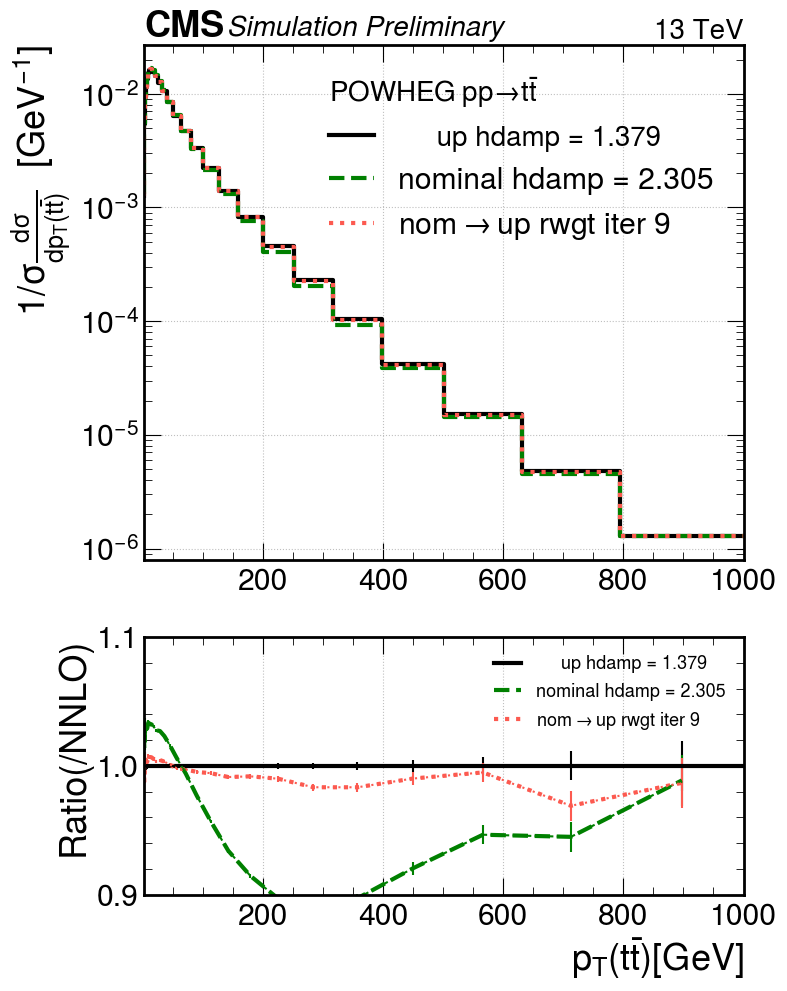


 iteration 9: chi2, mae, 
 5.566937076208093, 1618.6991883954024 



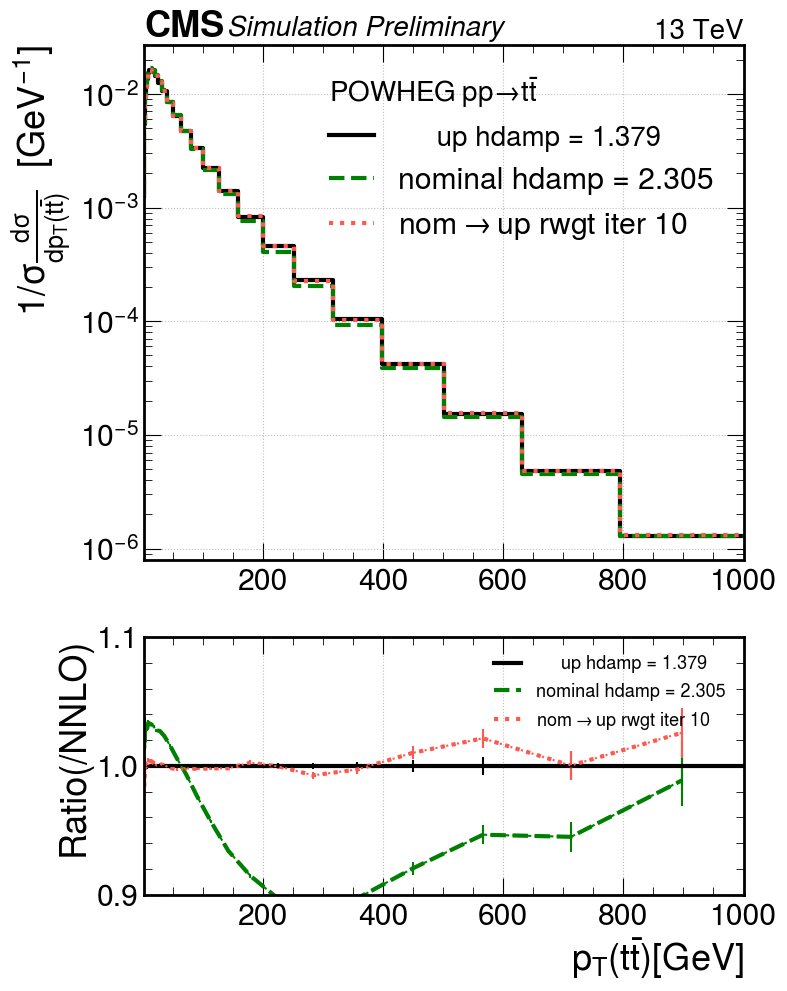


 iteration 10: chi2, mae, 
 1.3810898990548892, 710.9869241727016 



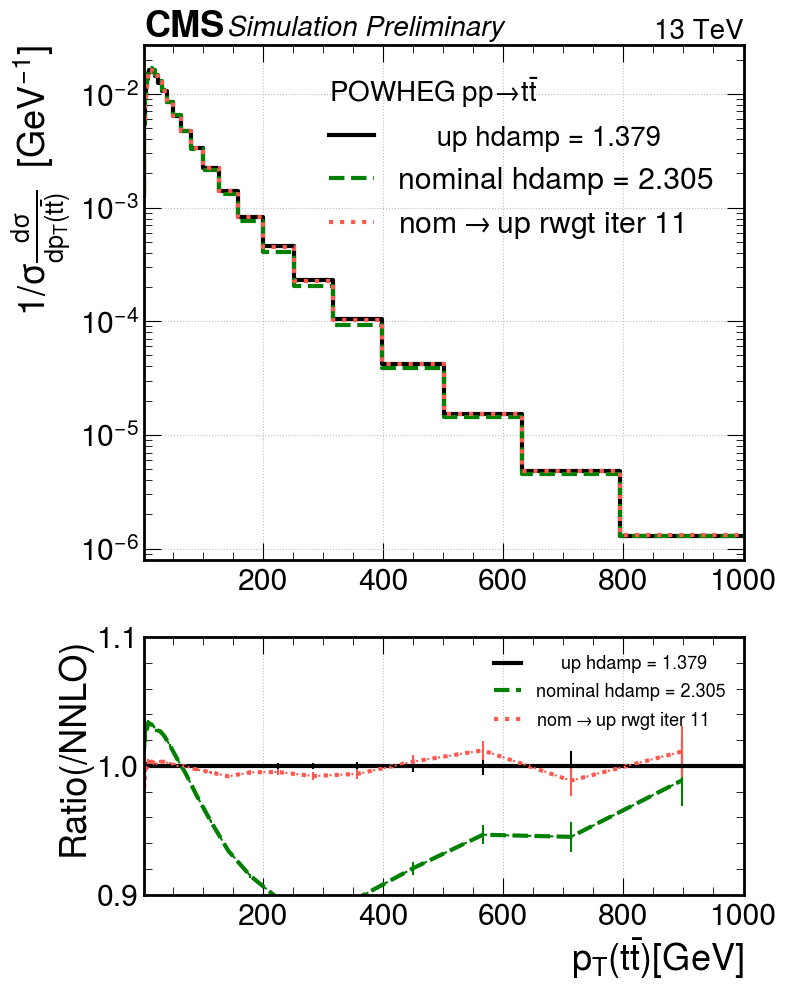


 iteration 11: chi2, mae, 
 2.294459191978807, 975.9656039204734 



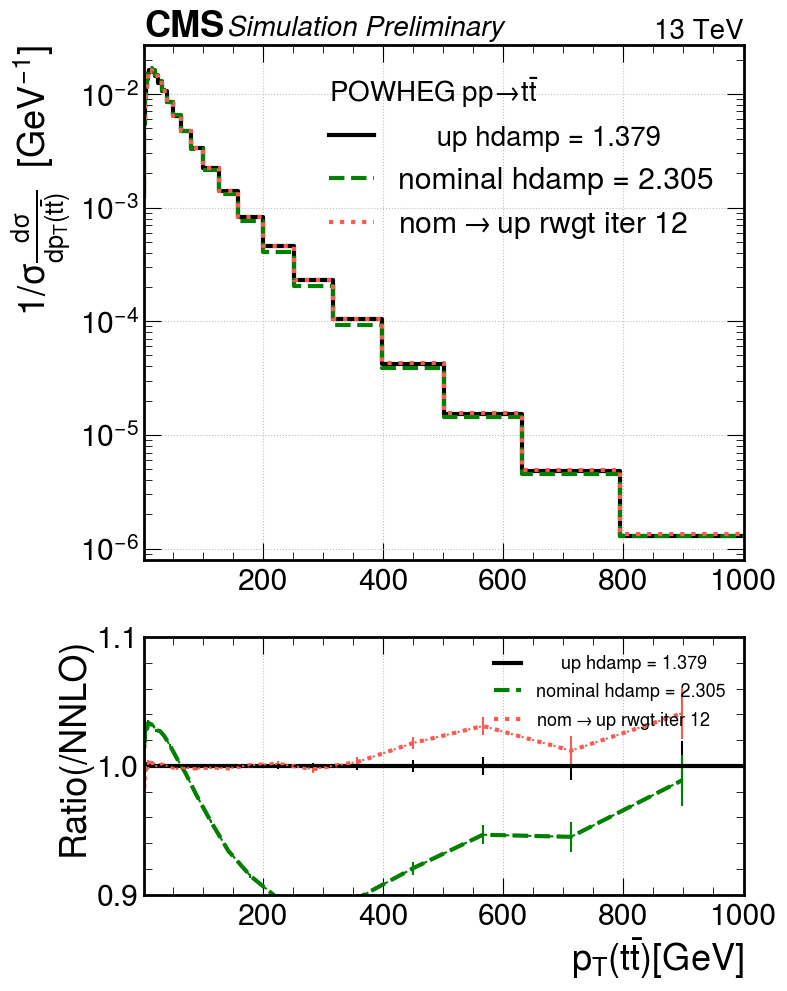


 iteration 12: chi2, mae, 
 1.29803666989275, 561.4452864743604 



In [61]:
# tt-pair pt
chi2_all = []
mae_all  = []

for i, wgts in enumerate(wgts_list):
    # setup args for plotting
    args = [(X0_plot[:,0], X0_plot_wgt, '     up hdamp = 1.379 '),
            (X1_plot[:,0], X1_plot_wgt, 'nominal hdamp = 2.305'),
            (X1_plot[:,0], wgts,      fr'nom$\rightarrow$up rwgt iter {i + 1}')]
    
    log_bins = np.logspace(np.log10(1), np.log10(1000), 31)
    DCTR.plot_ratio_cms(args, bins = log_bins, y_scale='log', ratio_ylim=[0.9, 1.1], part_label=r't\bar{t}', arg_label=r'p_{T}', unit=r' [GeV]', inv_unit=r' [GeV$^{-1}$]')
    # stats
    mae_list, chi2_list, p_list = DCTR.plot_ratio(args, bins = log_bins, stats_only = True, verbose=False)
    
    # last element is the one we're interested in, the others are the baseline nom and up
    print(f'\n iteration {i + 1}: chi2, mae, \n {chi2_list[-1]}, {mae_list[-1]} \n')

    chi2_all.append(chi2_list[-1])
    mae_all.append(mae_list[-1])



In [63]:
chi2_all = np.array(chi2_all)
mae_all = np.array(mae_all)

print(f'{chi2_all = }\n')

print(f'{mae_all = }\n')

min_chi2  = np.min(chi2_all)
max_chi2  = np.max(chi2_all)
mean_chi2 = np.mean(chi2_all)
std_chi2  = np.std(chi2_all)

min_mae   = np.min(mae_all)
max_mae   = np.max(mae_all)
mean_mae  = np.mean(mae_all)
std_mae   = np.std(mae_all)

print(f'chi2: min, max, mean, std\n\
{min_chi2:5f}, {max_chi2:5f}, {mean_chi2:5f}, {std_chi2:5f}\n')

print(f'chi2: min, max, mean, std\n\
{min_mae:5f}, {max_mae:5f}, {mean_mae:5f}, {std_mae:5f}\n')


chi2_all = array([1.1097 , 3.73102, 2.72123, 2.93283, 5.30385, 2.78611, 3.25371,
       0.78752, 5.56694, 1.38109, 2.29446, 1.29804])

mae_all = array([ 522.4284 , 1182.06298, 1140.05812, 1111.00918, 1646.63405,
       1087.31163, 1245.04809,  459.18131, 1618.69919,  710.98692,
        975.9656 ,  561.44529])

chi2: min, max, mean, std
0.787523, 5.566937, 2.763875, 1.484311

chi2: min, max, mean, std
459.181305, 1646.634047, 1021.735896, 379.144757



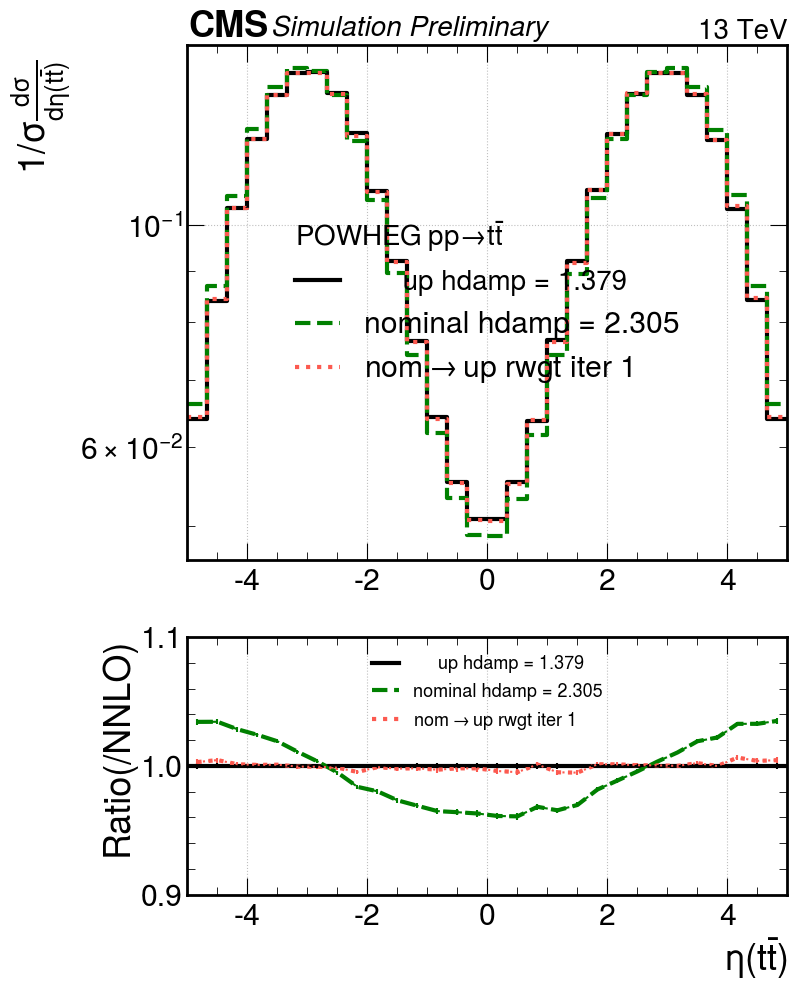

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 1: chi2, mae, 
 0.818527864672592, 464.54272836449127 



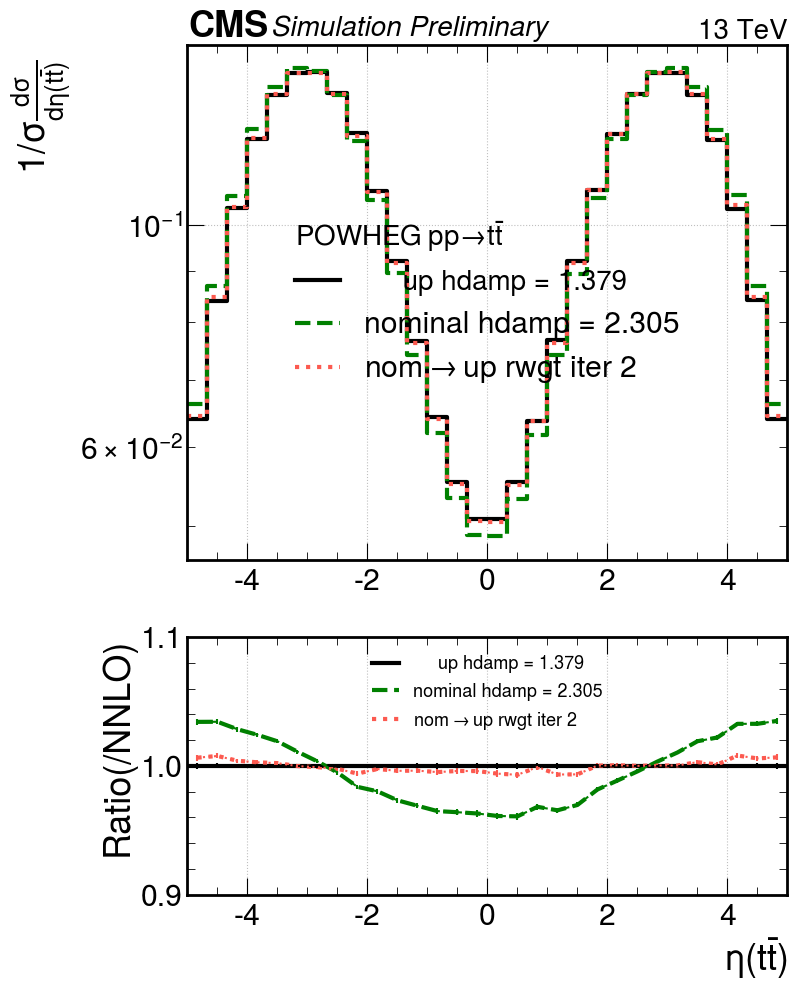

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 2: chi2, mae, 
 1.2552543669449825, 598.2523775776177 



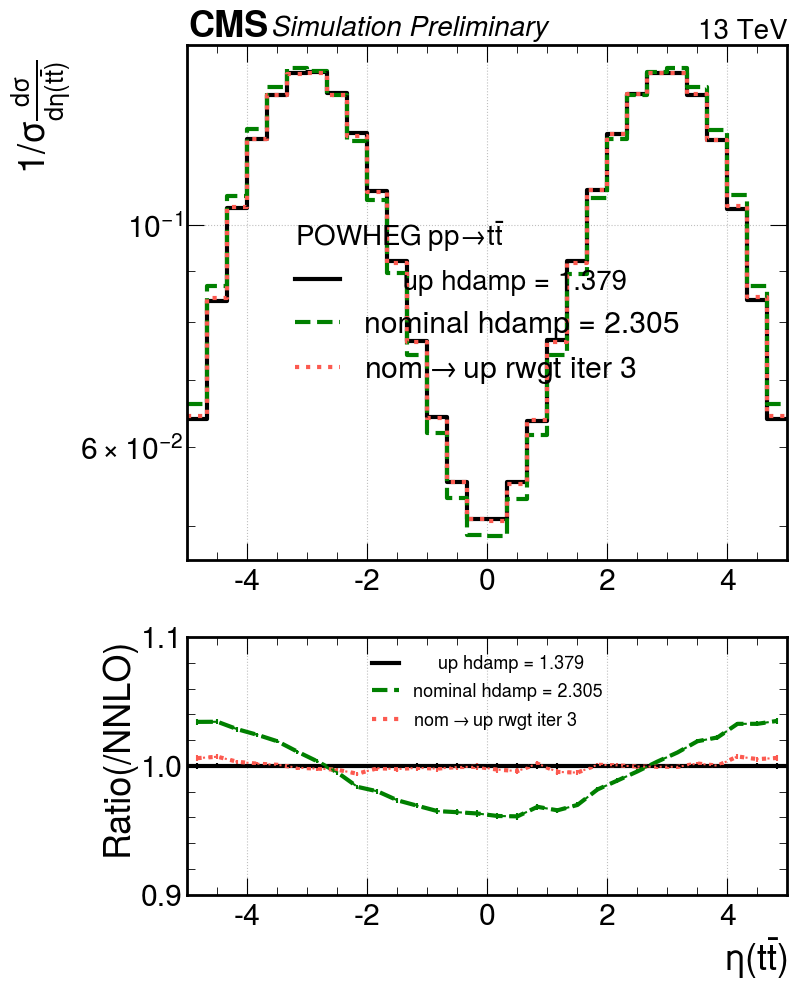

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 3: chi2, mae, 
 0.9756987824098051, 487.27277163365846 



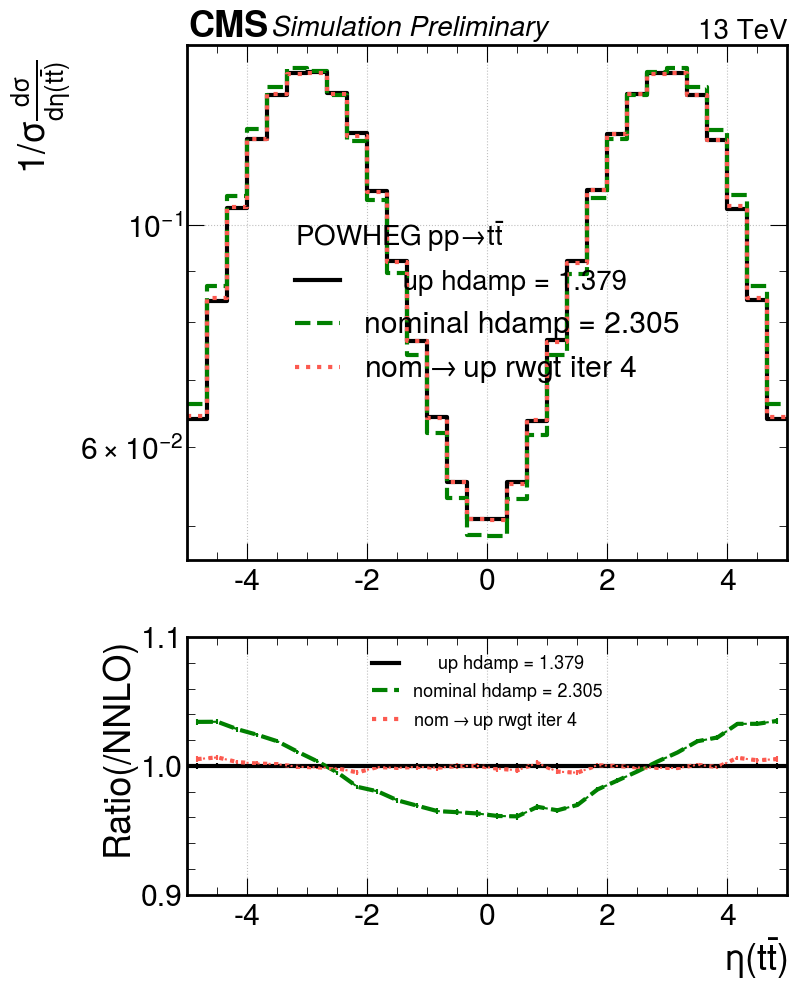

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 4: chi2, mae, 
 0.8223027409133917, 353.1461925717078 



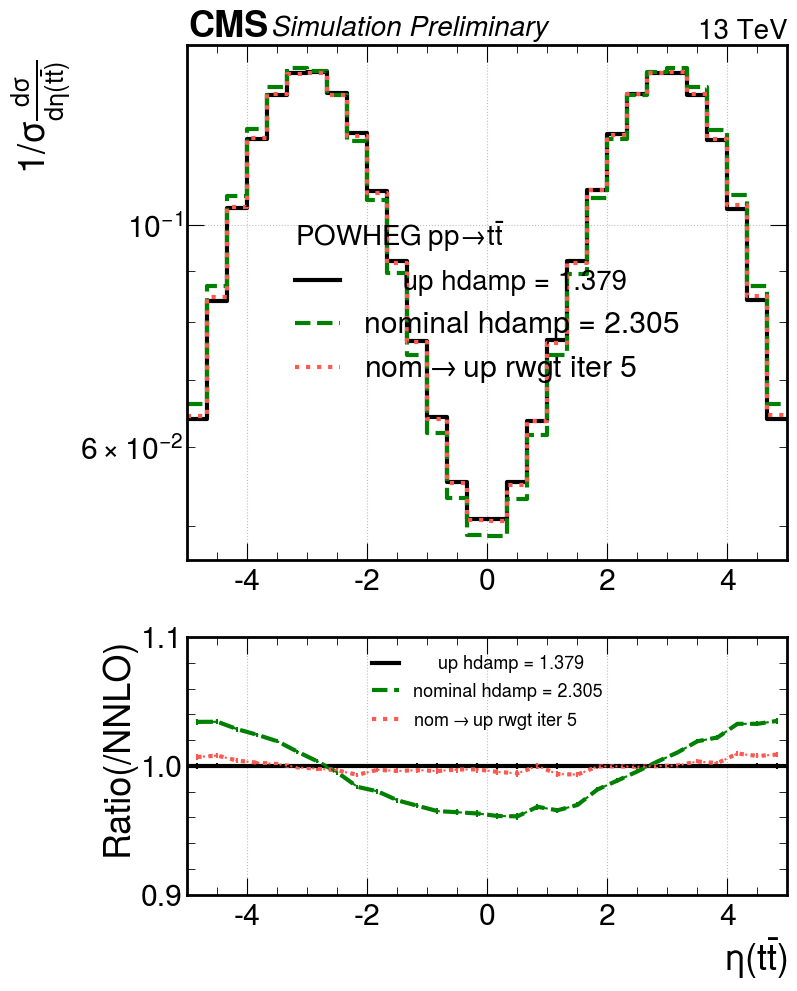

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 5: chi2, mae, 
 1.8126447087373299, 736.6911345843301 



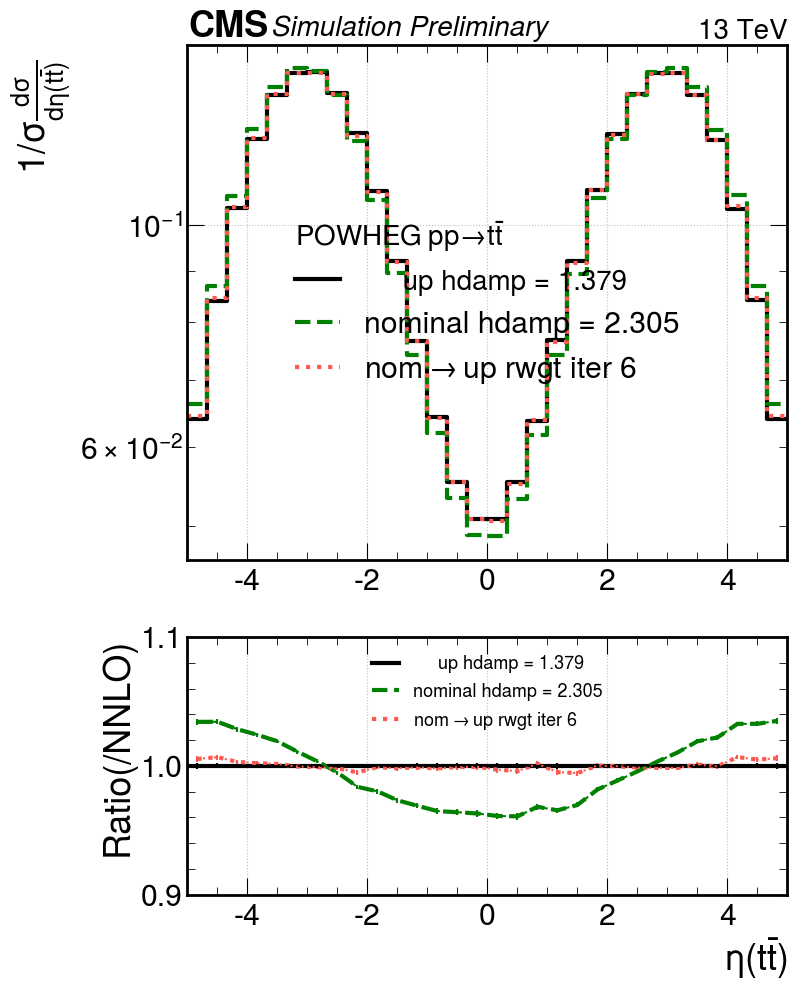

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 6: chi2, mae, 
 0.9311702096238812, 397.4998756449404 



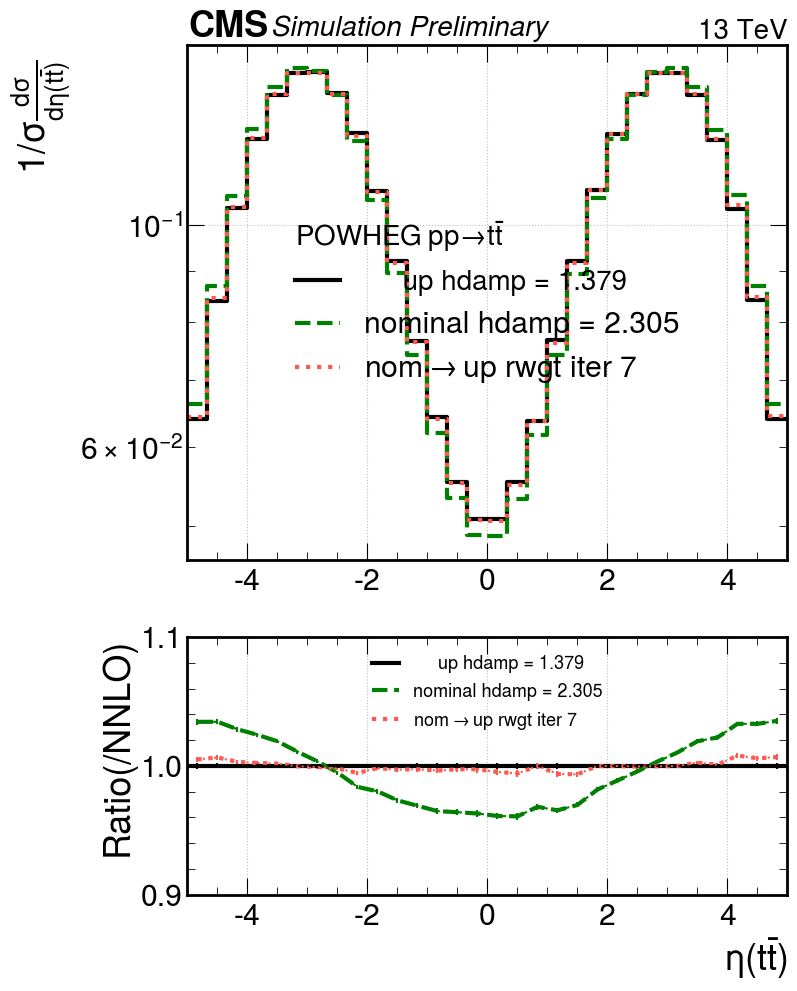

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 7: chi2, mae, 
 1.2384381918271918, 577.0112995859179 



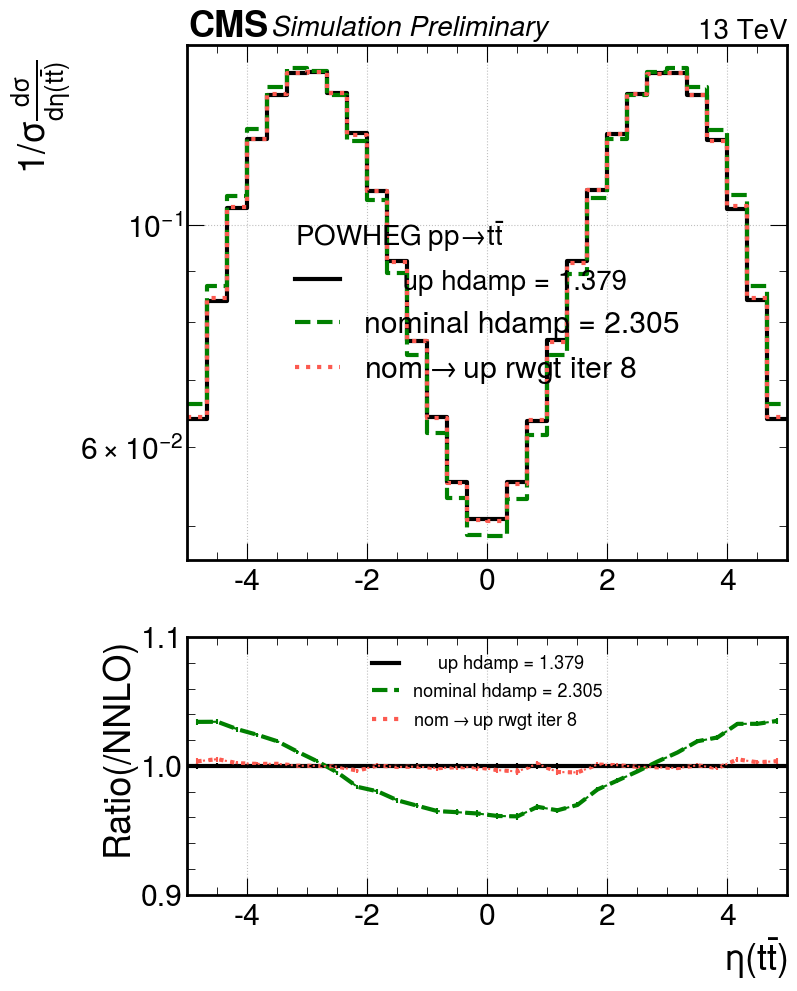

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 8: chi2, mae, 
 0.5917734967128977, 286.03106026916396 



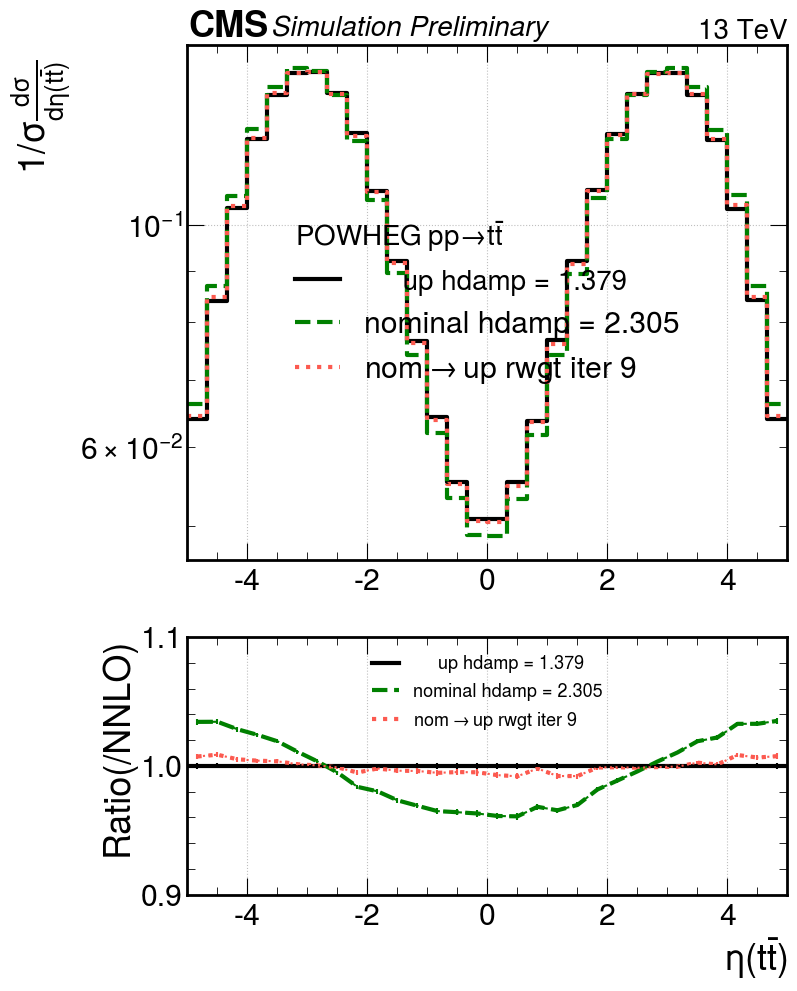

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 9: chi2, mae, 
 1.489515417236882, 590.3421150198849 



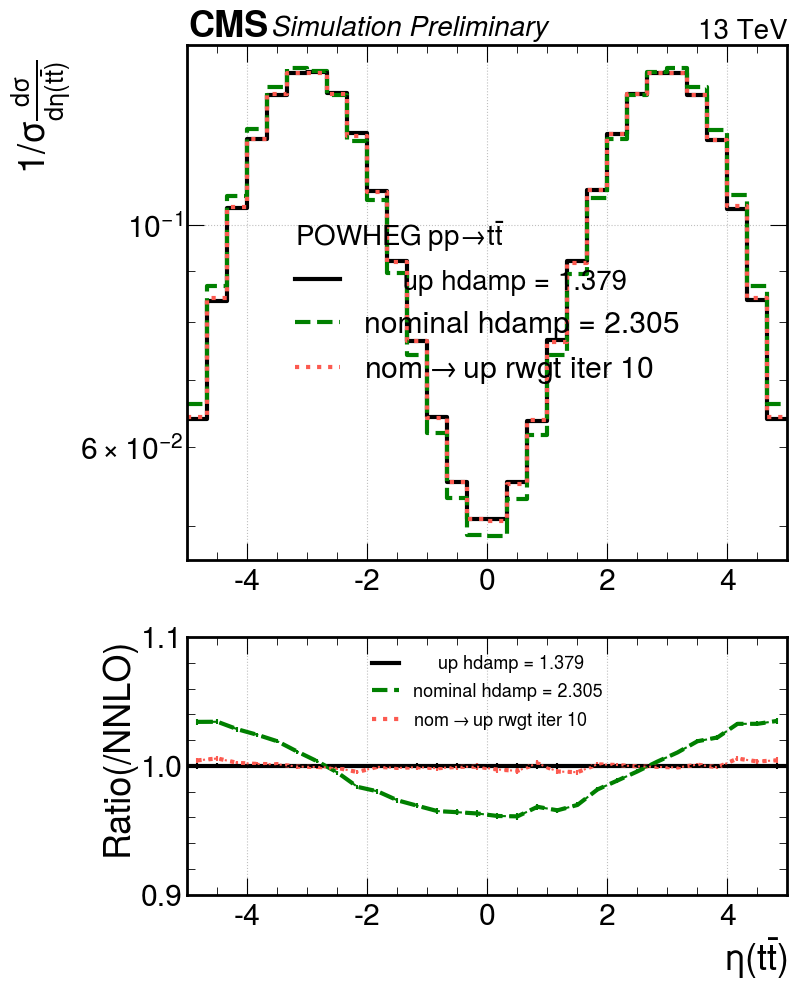

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 10: chi2, mae, 
 0.6688298307675978, 331.8606740279358 



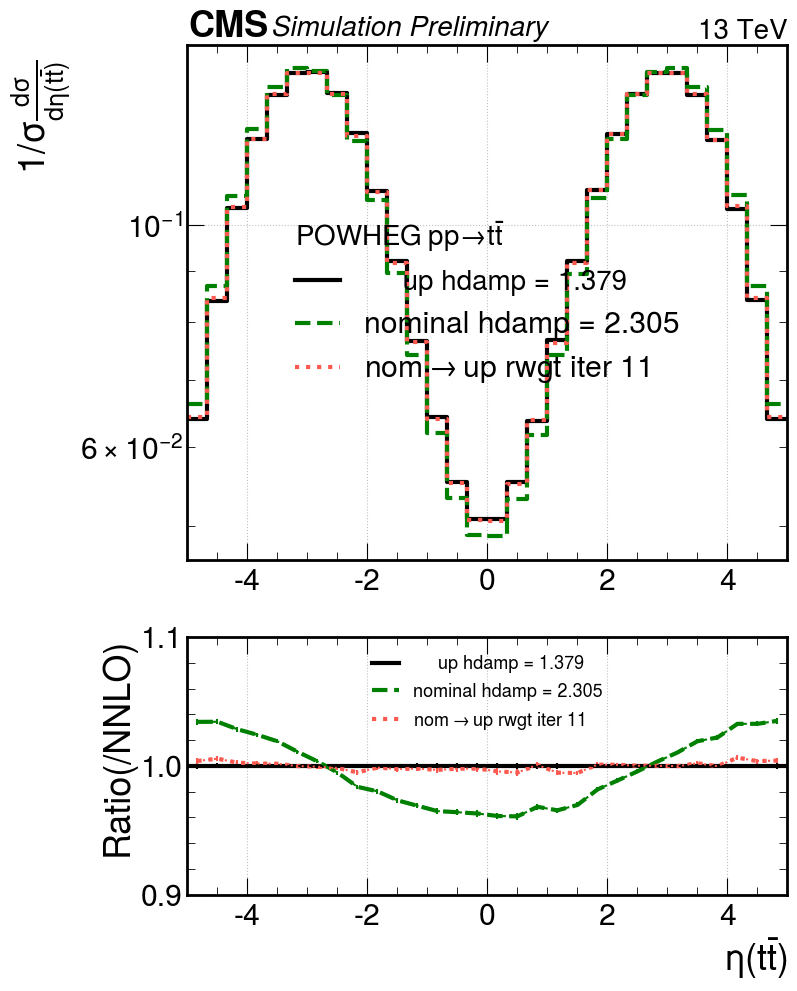

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 11: chi2, mae, 
 0.7975383596407535, 420.15999478712524 



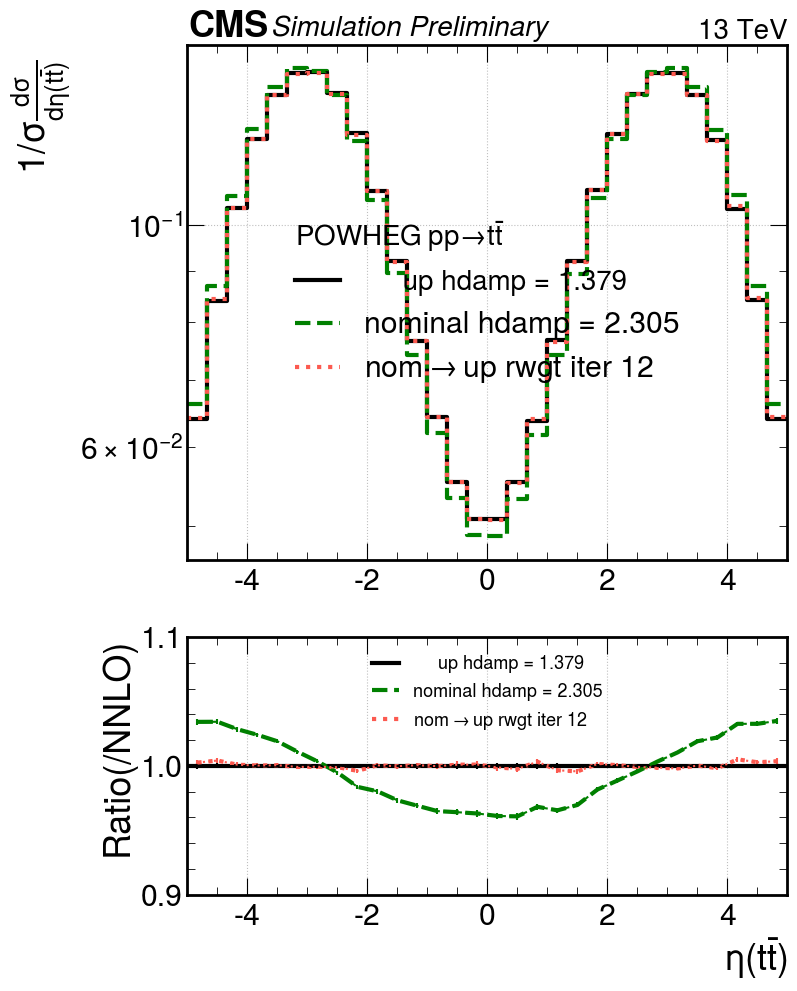

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 12: chi2, mae, 
 0.5896146603709483, 295.31820546255557 

chi2_all = array([0.81853, 1.25525, 0.9757 , 0.8223 , 1.81264, 0.93117, 1.23844,
       0.59177, 1.48952, 0.66883, 0.79754, 0.58961])

mae_all = array([464.54273, 598.25238, 487.27277, 353.14619, 736.69113, 397.49988,
       577.0113 , 286.03106, 590.34212, 331.86067, 420.15999, 295.31821])

chi2: min, max, mean, std
0.589615, 1.812645, 0.999276, 0.362581

chi2: min, max, mean, std
286.031060, 736.691135, 461.510702, 134.723689



In [65]:
# tt-pair eta
chi2_all = []
mae_all  = []

for i, wgts in enumerate(wgts_list):
    # setup args for plotting
    args = [(X0_plot[:,2], X0_plot_wgt, '     up hdamp = 1.379 '),
            (X1_plot[:,2], X1_plot_wgt, 'nominal hdamp = 2.305'),
            (X1_plot[:,2], wgts,      fr'nom$\rightarrow$up rwgt iter {i + 1}')]
    
    bins = np.linspace(-5, 5, 31)
    DCTR.plot_ratio_cms(args, bins = bins, y_scale='log', ratio_ylim=[0.9, 1.1], part_label=r't\bar{t}', arg_label=r'\eta', unit=r' ', inv_unit=r' ')
    # stats
    mae_list, chi2_list, p_list = DCTR.plot_ratio(args, bins = log_bins, stats_only = True, verbose=False)
    
    # last element is the one we're interested in, the others are the baseline nom and up
    print(f'\n iteration {i + 1}: chi2, mae, \n {chi2_list[-1]}, {mae_list[-1]} \n')

    chi2_all.append(chi2_list[-1])
    mae_all.append(mae_list[-1])

chi2_all = np.array(chi2_all)
mae_all = np.array(mae_all)

print(f'{chi2_all = }\n')

print(f'{mae_all = }\n')

min_chi2  = np.min(chi2_all)
max_chi2  = np.max(chi2_all)
mean_chi2 = np.mean(chi2_all)
std_chi2  = np.std(chi2_all)

min_mae   = np.min(mae_all)
max_mae   = np.max(mae_all)
mean_mae  = np.mean(mae_all)
std_mae   = np.std(mae_all)

print(f'chi2: min, max, mean, std\n\
{min_chi2:5f}, {max_chi2:5f}, {mean_chi2:5f}, {std_chi2:5f}\n')

print(f'chi2: min, max, mean, std\n\
{min_mae:5f}, {max_mae:5f}, {mean_mae:5f}, {std_mae:5f}\n')
